In [1]:
import pickle
import _pickle as cPickle
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import DistilBertTokenizerFast
from transformers import LlamaForCausalLM, LlamaTokenizer

2024-05-14 17:15:15.717168: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 17:15:15.918543: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 17:15:15.918703: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 17:15:15.919326: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 17:15:16.036453: I tensorflow/core/platform/cpu_feature_g

In [2]:
# vocab_clinical = pickle.load(open('../SeqModel/all_vocab_clinical_new.sav', 'rb'))


# data_clinical = pd.read_feather('../SeqModel/all_data_clinical_new.feather')


# vocab_stat_clinical = pd.read_csv('../FinalData/pivotClinicalCodesbyCountry.csv')
# vocab_stat_therapy = pd.read_csv('../FinalData/pivotTherapyCodesbyCountry.csv')

data = pickle.load(open('../Clean_data/clinical_data.sav', 'rb'))
dataDesc = pickle.load(open('../Clean_data/NewDataWithDesc.sav', 'rb'))
ReadAll = pd.read_csv('../Clean_data/Read-Desc.csv')

# # read2desc = read2desc.drop_duplicates('CC')
# read2desc.reset_index(drop=True, inplace=True)


In [3]:
trainingData, validationData, internalEvaluationData, evaluationData, evaluationDataWales, evaluationDataScotland = pickle.load(open('../FinalData/dataset_2vs1_15022024.sav', 'rb'))
features = pickle.load(open('../FinalData/cleaned_features_2vs1_15022024.sav', 'rb'))

In [4]:
newTrainingData = trainingData[['patid']].merge(
    dataDesc, on='patid', how='inner').reset_index(drop=True)
newTrainingData = newTrainingData.merge(features[['patid', 'sex', 'age', 'cat_BMI', 'smokingStatus', 'ethnic_group', 'imd_decile', 'OutputAreaClassification']], on='patid', how='inner').reset_index(drop=True)


In [5]:
newTrainingData.shape

(378193, 9)

In [6]:
def fix_ethnic(x):
    if x == 'not_recorded':
        return 'unknown ethnicity'
    elif x == 'White - ethnic group':        
        return 'White ethnicity'
    elif x == 'Other ethnic group':
        return 'other ethnicity'
    elif x == 'Asian - ethnic group':
        return 'Asian ethnicity'
    elif x == 'Black - ethnic group':
        return 'Black ethnicity'
    elif x == 'Mixed ethnic census group':
        return 'Mixed ethnicity'
    
def fix_BMI(x):
    if x == 'normal':
        return 'normal BMI'
    elif x == 'obese':        
        return 'obese BMI'
    elif x == 'overweight':
        return 'overweight BMI'
    elif x == 'not recorded':
        return 'unknown BMI'
    elif x == 'underweight':
        return 'underweight BMI'



In [7]:
newTrainingData['sex'] = newTrainingData.sex.apply(lambda x: 'female' if x == 0 else 'male')
newTrainingData['age'] = newTrainingData.age.apply(lambda x: str(x) + ' years old')
newTrainingData['OutputAreaClassification'] = newTrainingData.OutputAreaClassification.apply(lambda x: x.replace(';', ', '))
newTrainingData['imd_decile'] = newTrainingData.imd_decile.apply(lambda x: 'imd decile ' + str(x) + ' area')
newTrainingData['cat_BMI'] = newTrainingData.cat_BMI.apply(lambda x: fix_BMI(x))
newTrainingData['ethnic_group'] = newTrainingData.ethnic_group.apply(lambda x: fix_ethnic(x))


In [8]:
newTrainingData['profile'] = newTrainingData.apply(lambda x: x.ethnic_group + ' ' + x.sex + ', ' + x.age + ', ' 
                                                       + x.smokingStatus + ', with ' + x.cat_BMI + ', and lives in a ' 
                                                       + x.OutputAreaClassification +' area.', axis=1)
newTrainingData['full_text'] = newTrainingData.apply(lambda x: x.profile + ' ' + x.TERM60, axis=1)
newTrainingData['seq_length'] = newTrainingData.full_text.apply(lambda x: len(x.split()))
newTrainingData['profile_length'] = newTrainingData.profile.apply(lambda x: len(x.split()))

<Axes: >

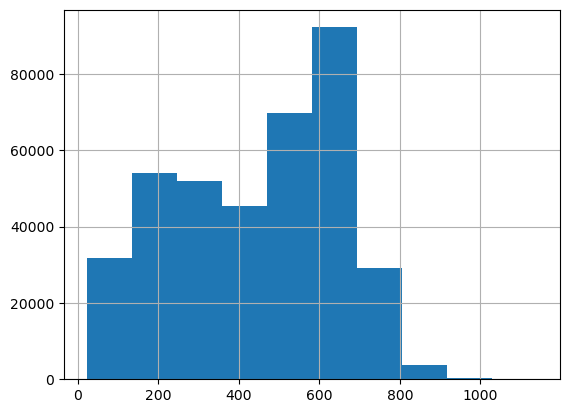

In [9]:
newTrainingData.seq_length.hist()

<Axes: >

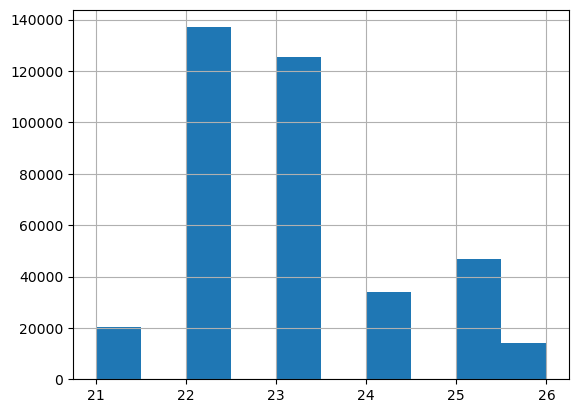

In [10]:
newTrainingData.profile_length.hist()

In [11]:
newTrainingData = newTrainingData.merge(data, on='patid', how='left').newTrainingData.reset_index(drop=True)

In [13]:
newTrainingData.shape

(378193, 21)

In [15]:
newTrainingData.columns

Index(['patid', 'TERM60', 'sex', 'age_x', 'cat_BMI', 'smokingStatus',
       'ethnic_group', 'imd_decile', 'OutputAreaClassification', 'profile',
       'full_text', 'seq_length', 'profile_length', 'Country', 'age_y',
       'read_code_seq_padded_noPAD', 'text', '3months', '6months', '9months',
       '12months'],
      dtype='object')

In [16]:
pickle.dump(newTrainingData[['patid', 'full_text', '3months', '6months', '9months',
       '12months']], open('../Clean_data/clinical+profile_training.sav', 'wb'))

In [ ]:
longData = data.explode('read_code_seq_padded_noPAD')
longData.reset_index(drop=True, inplace=True)
longData.shape

In [ ]:
longData = longData.merge(ReadAll[['CC', 'TERM60']], how='left', left_on='read_code_seq_padded_noPAD', right_on='CC',)
longData.shape

In [ ]:
longData['CC'] = longData.CC.fillna('unknnownReadCodes')
longData['TERM60'] = longData.TERM60.fillna('unknnown Read code')

In [ ]:
longData = longData.groupby('patid').agg({'TERM60': lambda x: ". ".join(x)}).reset_index()

In [ ]:
pickle.dump(longData, open('../Clean_data/NewDataWithDesc.sav', 'wb'))

In [ ]:
data = data.merge(longData, on='patid')
pickle.dump(data, open('../Clean_data/Clinical_data_WithDesc.sav', 'wb'))

In [ ]:
data

In [ ]:
target_outcomes = '12months'
ignore, use = train_test_split(data, stratify=data[target_outcomes], test_size=0.2, random_state=1234)
search_train, search_val = train_test_split(use, stratify=use[target_outcomes], test_size=0.2, random_state=1234)
search_train.reset_index(inplace=True, drop=True)
search_val.reset_index(inplace=True, drop=True)
print(search_train.shape)
print(search_val.shape)


In [ ]:
# search_train[['Desc']].to_csv('../SeqModel/DescDataset.csv', index_label=False, index=False)

In [ ]:
train_texts = search_train['TERM60'].values.tolist()
train_labels = search_train['12months'].values.tolist()
val_texts = search_val['TERM60'].values.tolist()
val_labels = search_val['12months'].values.tolist()

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(train_texts, train_labels, test_size=.2)

In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
# tokenizer = AutoTokenizer.from_pretrained("AdaptLLM/medicine-LLM")


In [ ]:
texts = newTrainingData[:100]['full_text'].values.tolist()
train_encodings = tokenizer(texts, truncation=True, padding=True, max_length = 500)
train_labels = newTrainingData.age.values.tolist()

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length = 500)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length = 500)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length = 500)

In [ ]:
import torch

class GetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = GetDataset(train_encodings, train_labels)
# train_dataset = GetDataset(train_encodings, train_labels)
# val_dataset = GetDataset(val_encodings, val_labels)
# test_dataset = GetDataset(test_encodings, test_labels)

In [ ]:
len(train_dataset.encodings['input_ids'][0])

In [ ]:
#######################ONLY ACCURACY#########################################


# training_args = TrainingArguments(
#     output_dir='./results',          # output directory
#     num_train_epochs=3,              # total number of training epochs
#     per_device_train_batch_size=64,  # batch size per device during training
#     per_device_eval_batch_size=64,   # batch size for evaluation
#     warmup_steps=500,                # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,               # strength of weight decay
#     logging_dir='./logs',            # directory for storing logs
#     logging_steps=10,
# )

# model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

# trainer = Trainer(
#     model=model,                         # the instantiated 🤗 Transformers model to be trained
#     args=training_args,                  # training arguments, defined above
#     train_dataset=train_dataset,         # training dataset
#     eval_dataset=val_dataset             # evaluation dataset
# )

# trainer.train()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, log_loss
from torch.nn import CrossEntropyLoss
import numpy as np
from copy import deepcopy
from transformers import TrainerCallback

lang = 'en'

class CustomCallback(TrainerCallback):
    
    def __init__(self, trainer) -> None:
        super().__init__()
        self._trainer = trainer
    
    def on_epoch_end(self, args, state, control, **kwargs):
        if control.should_evaluate:
            control_copy = deepcopy(control)
            self._trainer.evaluate(eval_dataset=self._trainer.train_dataset, metric_key_prefix="train@"+lang)
            return control_copy

def compute_metrics(pred):
    global num_labels
    num_labels = 2
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    loss_fct = CrossEntropyLoss()
    logits = torch.tensor(pred.predictions)
    labels = torch.tensor(labels)
    loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
    return {
        # 'accuracy@'+lang: acc,
        'f1@'+lang: f1,
        'precision@'+lang: precision,
        'recall@'+lang: recall,
        'loss@'+lang: loss,
    }

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=64,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")
# model = AutoModelForCausalLM.from_pretrained("AdaptLLM/medicine-LLM")


trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.add_callback(CustomCallback(trainer)) 

train_result = trainer.train()

# trainer.evaluate(metric_key_prefix='test_en',
#                 eval_dataset=en_test_dataset)

In [ ]:
trainer.save_model("../Clean_data/ModelDesc10052024.mdl")

In [ ]:
pickle.dump(train_result, open('../Clean_data/Result_ModelDesc10052024.sav', 'wb'))

In [ ]:
val_metrics = trainer.evaluate(metric_key_prefix='val_en',
                eval_dataset=val_dataset)

In [ ]:
val_metrics

In [ ]:
test_metrics = trainer.evaluate(metric_key_prefix='test_en',
                eval_dataset=test_dataset)

In [ ]:
test_metrics

In [ ]:
val_metrics

In [ ]:
test_pred = trainer.predict(test_dataset)
preds = []
for x in test_pred.predictions:
    preds.append(np.argmax(x))

In [ ]:
test_pred.label_ids

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_pred.label_ids, preds)